Plik cached_PCA_VARIANCES_d01_comparison_I350_ababdfc56dfbc4e04d4032b9a0c051c83a5e728f.txt istnieje.
4 components should suffice
Plik cached_PCA_TSNE_d01_comparison_I350_424705a54dcea124129605b6a55e82d6e3463b67.txt nie istnieje.
Nowy plik cached_PCA_TSNE_d01_comparison_I350_424705a54dcea124129605b6a55e82d6e3463b67.txt
Plik cached_AC_d01_comparison_I350_5df55d31d76d12fbe2b5c3bf2422e3eb70bfa159.txt nie istnieje.
Nowy plik cached_AC_d01_comparison_I350_5df55d31d76d12fbe2b5c3bf2422e3eb70bfa159.txt
Cluster 0, length 4631188, mean 3.0184187326082883
Cluster 1, length 342611, mean 2.9636399072013337
Cluster 3, length 796876, mean 3.9344512720988645
Cluster 5, length 116503, mean 4.217423404955404
Cluster 6, length 570424, mean 4.184995657139677
Minimum error in label 1
[[[0.13602664 0.11069217 0.13458787 ... 0.333041   0.3048433  0.32393882]
  [0.16017629 0.09366261 0.05694103 ... 0.31052506 0.297839   0.30629772]
  [0.1368084  0.10244348 0.10574762 ... 0.31494534 0.2931707  0.31215197]
  ...

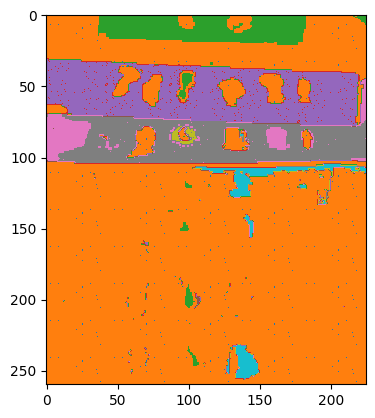

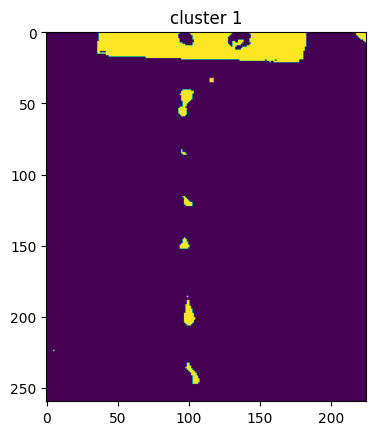

(2, 40984)
(2, 3032)
(2, 21)
(2, 7052)
(2, 92)
(2, 1031)
(2, 5048)
(2, 140)
(2, 555)
(2, 543)
(2, 2)


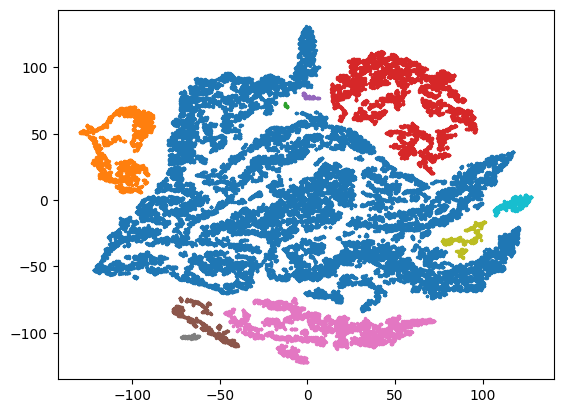

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from FileSystemCache import FileSystemCache
from sklearn.metrics import accuracy_score

MIN_CLUSTER_SIZE_TRESHOLD = 300

def zNormalized(data):
    mean = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)
    return (data - mean) / std_dev

# Kmeans on Xdr from pca
if __name__ == '__main__':
    fname = 'd01_frame_I300'
    fname = 'd01_comparison_I350'
    record = np.load(f'{fname}.npz')
    data = record['data']
    
    X = np.reshape(data, (-1, data.shape[-1]))
    rawX = np.reshape(data, (-1, data.shape[-1]))
    #X = zNormalized(rawX)

    blood_template = np.loadtxt("blood_template.txt")
    blood_template_raw = np.loadtxt("blood_template.txt")
    #blood_template = zNormalized(blood_template_raw)

    pcaModel = PCA(n_components=50)
    variance_ratio_closure = lambda: pcaModel.fit(X).explained_variance_ratio_
    explained_variance_ratio = FileSystemCache(variance_ratio_closure, f"cached_PCA_VARIANCES_{fname}") \
        .set_dependencies(X, pcaModel.get_params()) \
        .execute()
    
    n_components = np.count_nonzero(explained_variance_ratio[explained_variance_ratio > 0.005])
    print(f"{n_components} components should suffice")

    pcaModel = PCA(n_components=n_components)
    tsneModel = TSNE(n_components=2, perplexity=40)
    
    # execute initial dimmentional reduction with PCA for effeciency
    # finalize dimmentional reduction with TSNE for better visualization
    dimmention_reduction_closure = lambda data: tsneModel.fit_transform(pcaModel.fit_transform(data))
    #dimmention_reduction_closure = lambda data: pcaModel.fit_transform(data)
    tsne = FileSystemCache(dimmention_reduction_closure, f"cached_PCA_TSNE_{fname}") \
        .set_dependencies(pcaModel.get_params(), tsneModel.get_params(), 2) \
        .execute(X)

    dbscanModel = DBSCAN(eps=4.5)
    # Cluster results and get their cluster labels
    clustering_labeling_closure = lambda: dbscanModel.fit(tsne).labels_
    labels = FileSystemCache(clustering_labeling_closure, filename=f"cached_AC_{fname}") \
        .set_dependencies(tsne, dbscanModel.get_params()) \
        .execute()

    best_error_value = None
    best_label = -1
    label_errors = []
    for i, label in enumerate(set(labels)):
        current = X[labels == label]
        if len(current) > 1000:
            # euclidean distance to blood_template
            error_value = np.mean([la.norm(x / np.max(x) - blood_template) for x in current], axis=0)
            print(f'Cluster {i}, length {np.count_nonzero(current)}, mean {np.mean(error_value)}')
            label_errors.append(np.mean(error_value))
        else:
            label_errors.append(9999)
    label_with_minimum_error = np.argmin(label_errors)
    result = labels == label_with_minimum_error
    print(f'Minimum error in label {label_with_minimum_error}')
    
    #verify(record, result)
    
    print(data)
    plt.figure('All labels')
    labels2 = np.reshape(labels, data.shape[:2])
    plt.imshow(labels2, cmap=plt.cm.tab10)

    plt.figure('Results')
    newLabels = (labels2 == label_with_minimum_error).astype(int)
    plt.title(f"cluster {label_with_minimum_error}")
    plt.imshow(newLabels)
    plt.show()

    for label in set(labels):
        v = tsne[labels == label].T
        print(v.shape)
        plt.scatter(v[0], v[1], s=2)
    # for label in set(labels):

    #     dis = [np.mean(la.norm(x - blood_template)) for x in X[labels == label]]
    #     plt.title(f"cluster {label}")
    #     plt.bar(x=[x for x in range(len(blood_template))], height=X[np.argmin(dis)])
    #     plt.bar(x=[x for x in range(len(blood_template))], height=blood_template, alpha=0.5)
    #     plt.show()
    

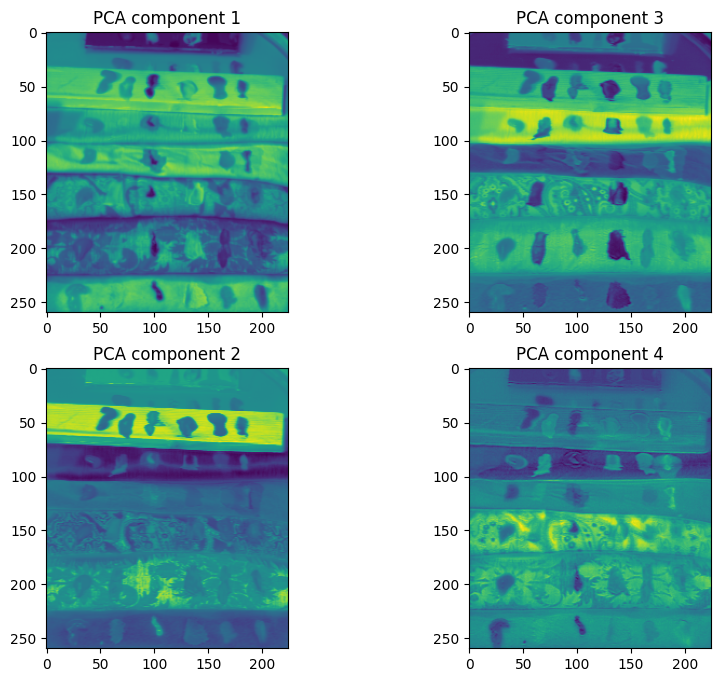

In [63]:
plotData = pcaModel.fit_transform(X).T

labels2 = np.reshape(labels, data.shape[:2])
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, component in enumerate(plotData):
    imageByComponentVariable = np.reshape(component, data.shape[:2])
    axs[i % 2, i // 2].set_title(f"PCA component {i+1}")
    axs[i % 2, i // 2].imshow(imageByComponentVariable)
plt.show()
